# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

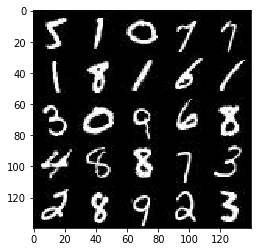

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

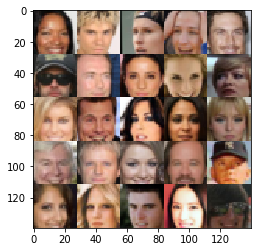

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def myconv2d(x, size):
    return tf.layers.conv2d(x, size, 5, strides=2, padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    training = not reuse
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = myconv2d(images, 64)
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = myconv2d(relu1, 128)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = myconv2d(relu2, 256)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse=not is_train
    alpha=0.2
    quantum=7
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, quantum*quantum*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, quantum, quantum, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())   
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    deps = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_dep = [dep for dep in deps if dep.name.startswith("discriminator")]
    g_dep = [dep for dep in deps if dep.name.startswith("generator")]
    
    with tf.control_dependencies(d_dep):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_dep):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    ## Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])            
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every = 20
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                ## Train Model
                steps += 1
                
                # batch images mapped to -1, 1
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

            train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
            train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
            print("Final of Epoch {}/{}...".format(epoch_i+1, epoch_count),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0646... Generator Loss: 2.9273
Epoch 1/2... Discriminator Loss: 0.0104... Generator Loss: 8.8037
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 1.1613
Epoch 1/2... Discriminator Loss: 0.8979... Generator Loss: 1.1879
Epoch 1/2... Discriminator Loss: 1.4277... Generator Loss: 0.5446


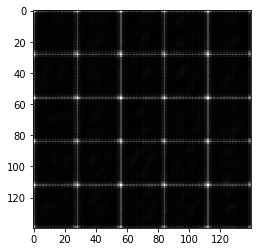

Epoch 1/2... Discriminator Loss: 1.1309... Generator Loss: 0.9467
Epoch 1/2... Discriminator Loss: 1.0457... Generator Loss: 1.6326
Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.4823
Epoch 1/2... Discriminator Loss: 1.2308... Generator Loss: 0.5483
Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 0.9957


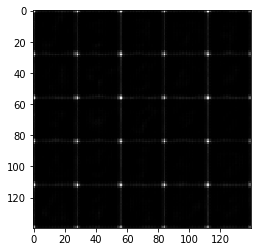

Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 0.9443
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 0.5955
Epoch 1/2... Discriminator Loss: 0.9740... Generator Loss: 1.1232
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.4332
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 0.4840


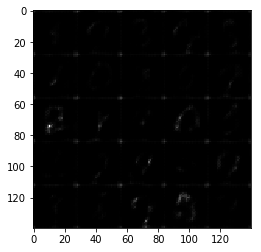

Epoch 1/2... Discriminator Loss: 1.5714... Generator Loss: 0.3185
Epoch 1/2... Discriminator Loss: 0.9904... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.4833
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 0.9566
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 0.6874


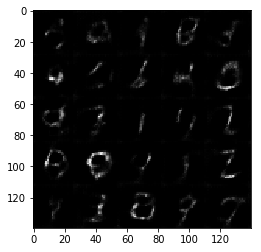

Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 0.7494
Epoch 1/2... Discriminator Loss: 1.1043... Generator Loss: 0.5837
Epoch 1/2... Discriminator Loss: 1.1230... Generator Loss: 1.2872
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 0.6565
Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 1.7743


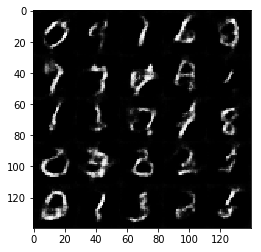

Epoch 1/2... Discriminator Loss: 1.0660... Generator Loss: 0.6885
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 1.1997
Epoch 1/2... Discriminator Loss: 1.2577... Generator Loss: 0.4797
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 0.5933


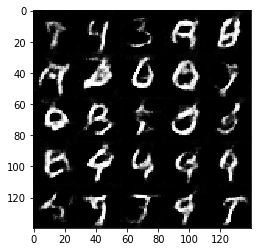

Epoch 1/2... Discriminator Loss: 1.1681... Generator Loss: 0.5175
Epoch 1/2... Discriminator Loss: 1.1404... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 0.6644
Epoch 1/2... Discriminator Loss: 0.9740... Generator Loss: 1.1406
Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 0.6629


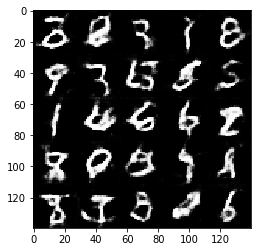

Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 0.5469
Epoch 1/2... Discriminator Loss: 1.0366... Generator Loss: 1.0446
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.5648
Epoch 1/2... Discriminator Loss: 1.7236... Generator Loss: 0.2483
Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 1.0537


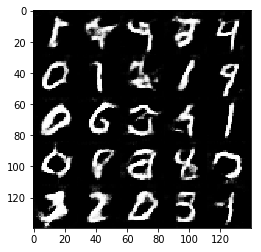

Epoch 1/2... Discriminator Loss: 1.0517... Generator Loss: 1.4712
Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 1.2315
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.4096
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 0.6229
Epoch 1/2... Discriminator Loss: 0.9755... Generator Loss: 1.0560


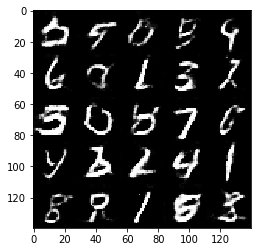

Epoch 1/2... Discriminator Loss: 1.1587... Generator Loss: 0.5527
Final of Epoch 1/2... Discriminator Loss: 0.8199... Generator Loss: 0.9728


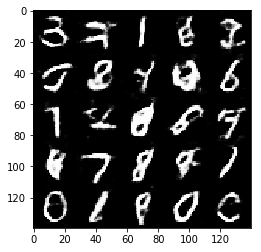

Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.6147
Epoch 2/2... Discriminator Loss: 0.8724... Generator Loss: 1.0773
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 0.8317
Epoch 2/2... Discriminator Loss: 0.9536... Generator Loss: 0.9621
Epoch 2/2... Discriminator Loss: 2.4092... Generator Loss: 0.1820


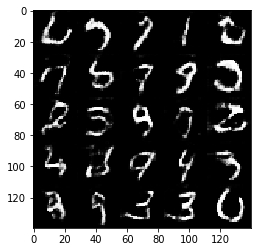

Epoch 2/2... Discriminator Loss: 1.0786... Generator Loss: 1.5642
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.0205
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.4986
Epoch 2/2... Discriminator Loss: 1.0673... Generator Loss: 0.7333
Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.3982


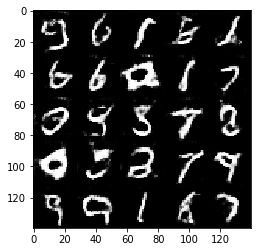

Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 0.7510
Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 1.0219
Epoch 2/2... Discriminator Loss: 1.0211... Generator Loss: 0.9868
Epoch 2/2... Discriminator Loss: 0.8252... Generator Loss: 0.8741
Epoch 2/2... Discriminator Loss: 1.1973... Generator Loss: 0.5380


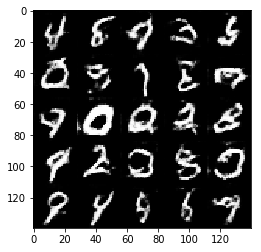

Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: 0.7263
Epoch 2/2... Discriminator Loss: 1.0547... Generator Loss: 0.9000
Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 0.4991
Epoch 2/2... Discriminator Loss: 0.7875... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 0.5014


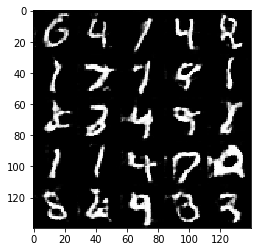

Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 0.6344
Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 0.5045
Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 1.7826
Epoch 2/2... Discriminator Loss: 1.6001... Generator Loss: 2.3957
Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 1.1285


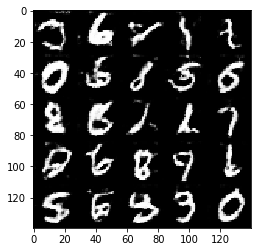

Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 1.3214
Epoch 2/2... Discriminator Loss: 0.8006... Generator Loss: 1.0124
Epoch 2/2... Discriminator Loss: 1.0593... Generator Loss: 0.5886
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 1.0242
Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.6589


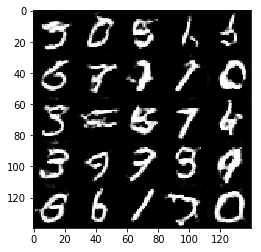

Epoch 2/2... Discriminator Loss: 0.7461... Generator Loss: 1.0543
Epoch 2/2... Discriminator Loss: 0.9892... Generator Loss: 1.0091
Epoch 2/2... Discriminator Loss: 0.6906... Generator Loss: 1.3807
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 0.6428
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 1.0526


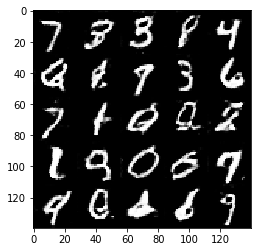

Epoch 2/2... Discriminator Loss: 1.0919... Generator Loss: 1.7905
Epoch 2/2... Discriminator Loss: 0.8711... Generator Loss: 1.0239
Epoch 2/2... Discriminator Loss: 0.7558... Generator Loss: 1.0856
Epoch 2/2... Discriminator Loss: 1.8914... Generator Loss: 0.2304
Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 0.9999


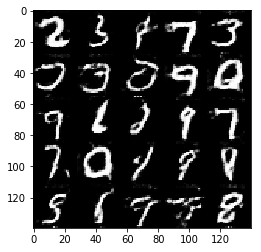

Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 0.8329
Epoch 2/2... Discriminator Loss: 1.0237... Generator Loss: 0.7185
Epoch 2/2... Discriminator Loss: 0.8695... Generator Loss: 0.8411
Epoch 2/2... Discriminator Loss: 0.7900... Generator Loss: 1.5303
Epoch 2/2... Discriminator Loss: 0.7928... Generator Loss: 0.9050


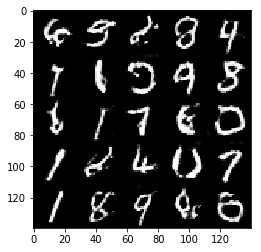

Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 0.6914
Final of Epoch 2/2... Discriminator Loss: 1.2876... Generator Loss: 0.4132


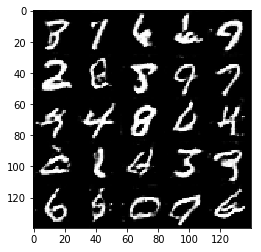

In [12]:
batch_size = 64
z_dim = 100
beta1 = 0.5
learning_rate = 0.0002

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2186... Generator Loss: 2.5409
Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 2.3965
Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 1.5462
Epoch 1/1... Discriminator Loss: 0.9158... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 2.6875


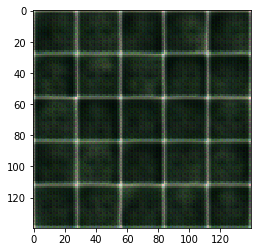

Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 2.0696
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 4.6157
Epoch 1/1... Discriminator Loss: 0.3699... Generator Loss: 1.9392
Epoch 1/1... Discriminator Loss: 0.3111... Generator Loss: 1.8572
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.5288


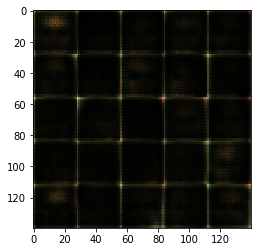

Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 1.8887
Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 2.8227
Epoch 1/1... Discriminator Loss: 0.2704... Generator Loss: 4.5672
Epoch 1/1... Discriminator Loss: 0.5480... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 1.0091


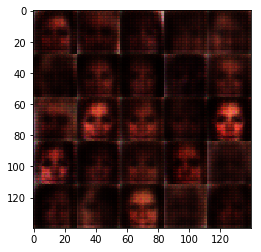

Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 5.0825
Epoch 1/1... Discriminator Loss: 0.4302... Generator Loss: 3.2426
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 3.0887
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 4.6023
Epoch 1/1... Discriminator Loss: 0.4481... Generator Loss: 3.7809


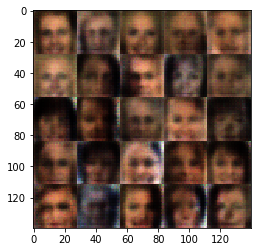

Epoch 1/1... Discriminator Loss: 1.6987... Generator Loss: 0.2805
Epoch 1/1... Discriminator Loss: 0.4224... Generator Loss: 1.7643
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 0.2808... Generator Loss: 2.2140
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.5162


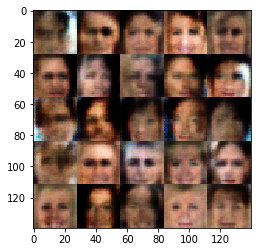

Epoch 1/1... Discriminator Loss: 0.2836... Generator Loss: 1.9382
Epoch 1/1... Discriminator Loss: 1.6673... Generator Loss: 0.2939
Epoch 1/1... Discriminator Loss: 0.2990... Generator Loss: 3.9430
Epoch 1/1... Discriminator Loss: 0.1300... Generator Loss: 4.9970
Epoch 1/1... Discriminator Loss: 1.6039... Generator Loss: 0.3316


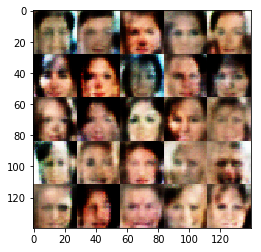

Epoch 1/1... Discriminator Loss: 0.2649... Generator Loss: 4.1736
Epoch 1/1... Discriminator Loss: 0.1728... Generator Loss: 3.6237
Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 1.7803
Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 0.3579... Generator Loss: 1.8566


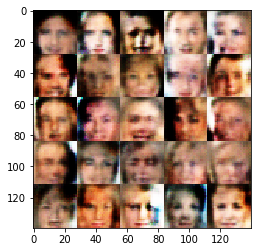

Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 5.1227
Epoch 1/1... Discriminator Loss: 0.2176... Generator Loss: 3.5302
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 1.6641
Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 0.2068... Generator Loss: 2.5158


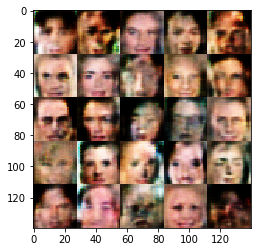

Epoch 1/1... Discriminator Loss: 1.9602... Generator Loss: 0.2235
Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 1.7999
Epoch 1/1... Discriminator Loss: 0.2673... Generator Loss: 2.3614
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 2.5516
Epoch 1/1... Discriminator Loss: 0.2557... Generator Loss: 1.9094


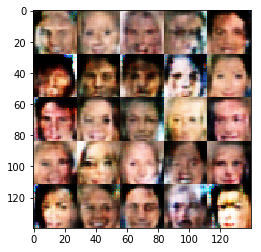

Epoch 1/1... Discriminator Loss: 0.2297... Generator Loss: 2.2323
Epoch 1/1... Discriminator Loss: 0.2251... Generator Loss: 2.0648
Epoch 1/1... Discriminator Loss: 0.1384... Generator Loss: 2.9843
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 4.9985
Epoch 1/1... Discriminator Loss: 0.1421... Generator Loss: 2.9182


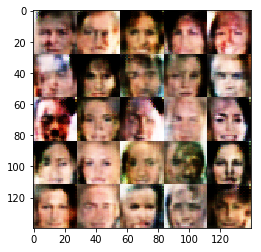

Epoch 1/1... Discriminator Loss: 0.2468... Generator Loss: 3.1315
Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 1.3210
Epoch 1/1... Discriminator Loss: 0.7464... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 2.3545
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 1.9439


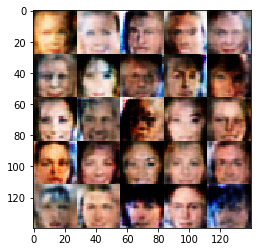

Epoch 1/1... Discriminator Loss: 0.2683... Generator Loss: 4.2226
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 4.4096
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 0.1398... Generator Loss: 2.8877


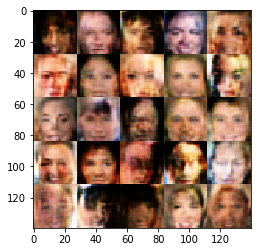

Epoch 1/1... Discriminator Loss: 0.1786... Generator Loss: 3.0164
Epoch 1/1... Discriminator Loss: 0.3231... Generator Loss: 1.9262
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 2.2377
Epoch 1/1... Discriminator Loss: 1.8588... Generator Loss: 3.4068


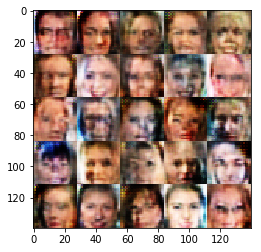

Epoch 1/1... Discriminator Loss: 0.1098... Generator Loss: 3.8659
Epoch 1/1... Discriminator Loss: 0.2043... Generator Loss: 2.6226
Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 3.3784
Epoch 1/1... Discriminator Loss: 0.2666... Generator Loss: 2.0355
Epoch 1/1... Discriminator Loss: 1.9189... Generator Loss: 3.7614


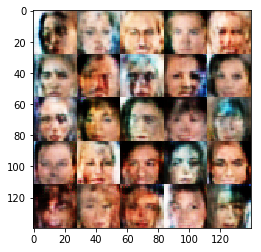

Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 0.1847... Generator Loss: 2.3084
Epoch 1/1... Discriminator Loss: 0.1031... Generator Loss: 3.6310
Epoch 1/1... Discriminator Loss: 0.0539... Generator Loss: 4.4051
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 4.2178


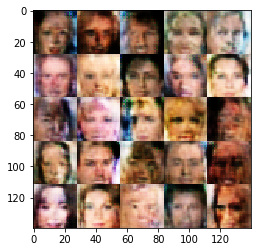

Epoch 1/1... Discriminator Loss: 0.2869... Generator Loss: 2.0231
Epoch 1/1... Discriminator Loss: 0.1777... Generator Loss: 2.3265
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 4.1380
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 2.0706
Epoch 1/1... Discriminator Loss: 0.2968... Generator Loss: 2.0198


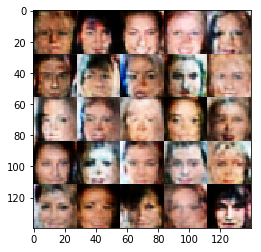

Epoch 1/1... Discriminator Loss: 0.2699... Generator Loss: 1.7258
Epoch 1/1... Discriminator Loss: 0.3289... Generator Loss: 2.6681
Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 1.2050
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 0.3558... Generator Loss: 2.2848


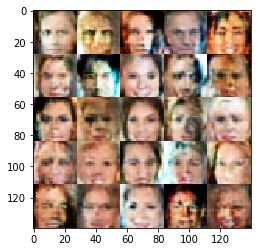

Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 2.1129
Epoch 1/1... Discriminator Loss: 0.1730... Generator Loss: 3.6149
Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 2.8234
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 1.9483
Epoch 1/1... Discriminator Loss: 0.2109... Generator Loss: 2.4527


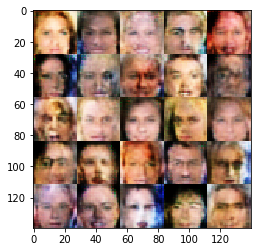

Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 1.3394
Epoch 1/1... Discriminator Loss: 0.5926... Generator Loss: 1.1722
Epoch 1/1... Discriminator Loss: 0.0711... Generator Loss: 4.0529
Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 2.1138
Epoch 1/1... Discriminator Loss: 0.1715... Generator Loss: 2.9556


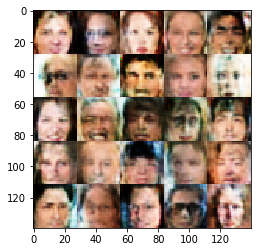

Epoch 1/1... Discriminator Loss: 0.2046... Generator Loss: 2.4499
Epoch 1/1... Discriminator Loss: 0.2958... Generator Loss: 3.6964
Epoch 1/1... Discriminator Loss: 0.2016... Generator Loss: 5.8156
Epoch 1/1... Discriminator Loss: 0.7719... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 0.2976... Generator Loss: 1.9747


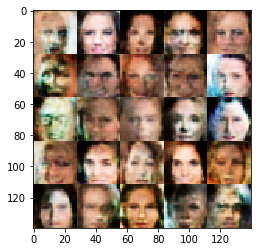

Epoch 1/1... Discriminator Loss: 0.0493... Generator Loss: 4.4615
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 3.1460
Epoch 1/1... Discriminator Loss: 0.3164... Generator Loss: 1.9743
Epoch 1/1... Discriminator Loss: 0.3823... Generator Loss: 1.4597
Epoch 1/1... Discriminator Loss: 0.1482... Generator Loss: 4.1563


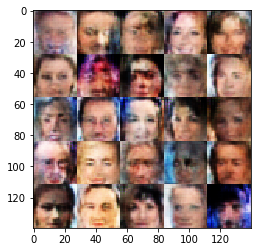

Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 1.4402
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 0.1886... Generator Loss: 2.1504
Epoch 1/1... Discriminator Loss: 0.3184... Generator Loss: 2.1595


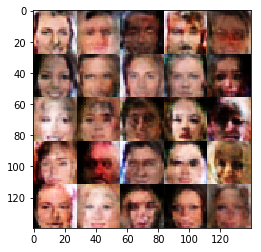

Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 1.3613
Epoch 1/1... Discriminator Loss: 0.2750... Generator Loss: 2.4107
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 1.1512
Epoch 1/1... Discriminator Loss: 0.0804... Generator Loss: 4.3048
Epoch 1/1... Discriminator Loss: 0.2616... Generator Loss: 2.1254


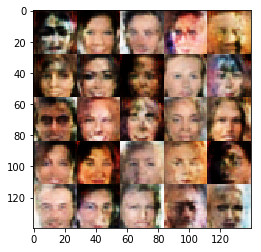

Epoch 1/1... Discriminator Loss: 0.0985... Generator Loss: 3.4124
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 1.8766
Epoch 1/1... Discriminator Loss: 0.3032... Generator Loss: 1.8651
Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 5.8751
Epoch 1/1... Discriminator Loss: 0.3228... Generator Loss: 2.3538


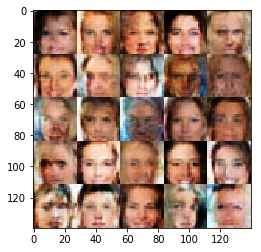

Epoch 1/1... Discriminator Loss: 0.2125... Generator Loss: 5.5717
Epoch 1/1... Discriminator Loss: 0.1325... Generator Loss: 3.3409
Epoch 1/1... Discriminator Loss: 1.8278... Generator Loss: 0.2384
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 2.6952


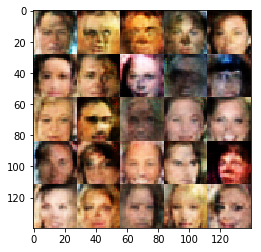

Epoch 1/1... Discriminator Loss: 0.2280... Generator Loss: 2.5725
Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 0.1185... Generator Loss: 4.3026
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 1.4767
Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 6.2442


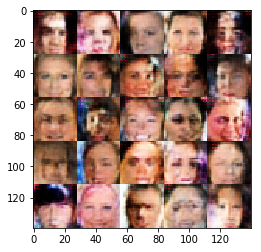

Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 0.3705... Generator Loss: 1.5151
Epoch 1/1... Discriminator Loss: 0.4821... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 1.8123
Epoch 1/1... Discriminator Loss: 0.0645... Generator Loss: 4.7233


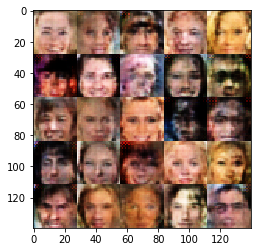

Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 1.5228
Epoch 1/1... Discriminator Loss: 0.5012... Generator Loss: 1.2159
Epoch 1/1... Discriminator Loss: 0.2184... Generator Loss: 2.2283
Epoch 1/1... Discriminator Loss: 0.3305... Generator Loss: 1.6481
Epoch 1/1... Discriminator Loss: 0.2075... Generator Loss: 2.6944


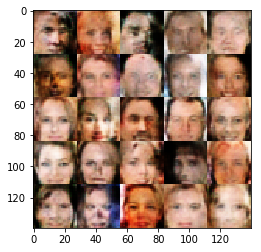

Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 1.9169
Epoch 1/1... Discriminator Loss: 0.1548... Generator Loss: 4.2372
Epoch 1/1... Discriminator Loss: 1.8387... Generator Loss: 5.1344
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 0.1985... Generator Loss: 3.3608


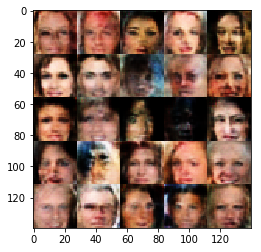

Epoch 1/1... Discriminator Loss: 0.0267... Generator Loss: 7.0939
Epoch 1/1... Discriminator Loss: 0.2717... Generator Loss: 2.2657
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.4732
Epoch 1/1... Discriminator Loss: 0.1297... Generator Loss: 3.2422
Epoch 1/1... Discriminator Loss: 0.2934... Generator Loss: 2.1744


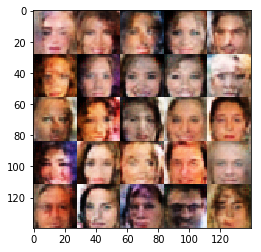

Epoch 1/1... Discriminator Loss: 0.2921... Generator Loss: 2.0459
Epoch 1/1... Discriminator Loss: 0.3649... Generator Loss: 1.7830
Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 6.1194
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 4.7279
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 2.4470


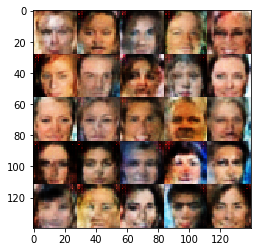

Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 2.4834
Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 1.6248
Final of Epoch 1/1... Discriminator Loss: 0.3394... Generator Loss: 1.7456


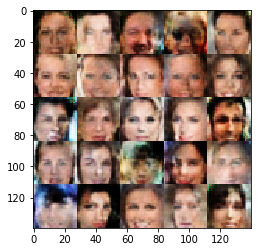

In [13]:
z_dim = 100
batch_size = 64
beta1 = 0.5
learning_rate = 0.0002

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.